# Text Classification

### Loadin Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Scikit-Learn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from umap import UMAP

# Data Visualization
import matplotlib.pyplot as plt

# Warnings
import warnings

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn.functional import cross_entropy

# Transformers
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
from transformers import pipeline

In [2]:
# Warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks

from install import *
install_requirements(is_chapter2=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (289/289), done.
remote: Total 526 (delta 251), reused 481 (delta 231), pack-reused 0
Receiving objects: 100% (526/526), 29.30 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (251/251), done.
/Users/isisromero/Desktop/NLP_transformer/chap_02/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [4]:
import torch
print(torch.__version__)

2.2.0


In [5]:
from datasets import load_dataset

In [6]:
from utils import *
setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Using transformers v4.40.1
Using datasets v2.19.0


### The Dataset

#### A First Look at Hugging Face Datasets

In [7]:
# # Deprecatede version
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 136393 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2',
'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news',
'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [8]:
# from huggingface_hub import list_datasets

# datasets_generator = list_datasets()

# all_datasets = list(datasets_generator)

# print(f"There are {len(all_datasets)} datasets currently available on the Hub")
# print(f"The first 10 are: {all_datasets[:10]}")

In [9]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [10]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
# Setting train dataset
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [12]:
# Checking length
len(train_ds)

16000

In [13]:
# Accessing index
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [14]:
train_ds.column_names

['text', 'label']

In [15]:
# Accessing feature attributes as follow:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [16]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [17]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Sidebar: What If My Dataset Is Not on the Hub?

In [18]:
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2024-04-24 17:09:22--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 2600:9000:20f4:b600:17:b174:6d00:93a1, 2600:9000:20f4:6000:17:b174:6d00:93a1, 2600:9000:20f4:9800:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:20f4:b600:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  9.24MB/s    in 0.2s    

2024-04-24 17:09:23 (9.24 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [19]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


In [20]:
# Performed locally as follow:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
# Performed remotely as follow:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

### From Datasets to DataFrames

In [22]:
# Setting DataFrame as follow:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


#### Setting proper label's cardinality

In [23]:
# Switching procedure from integer to string as follow:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at The Class Distribution

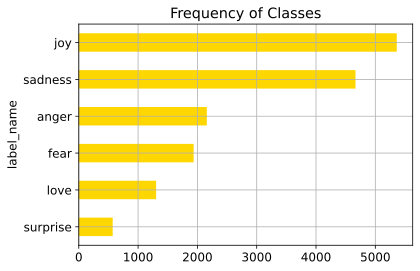

In [24]:
# Checking on example's distribution as follow:
df["label_name"].value_counts(ascending=True).plot.barh(color='gold')
plt.title("Frequency of Classes")
plt.grid(True)
plt.show()

### How Long Are Our Tweets?

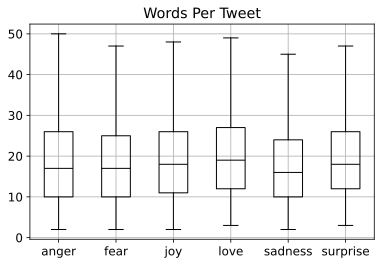

In [25]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.grid(True)
plt.show()

In [26]:
emotions.reset_format()

### From Text to Tokens

#### Character Tokenization

In [27]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [28]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [29]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [30]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [31]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [32]:
# Setting & switching into PyTorch tensor
input_ids = torch.tensor(input_ids)
# One-hot encoding as follows:
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [33]:
# First (1) vector examination 
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [34]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#### Subword Tokenization

In [35]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [36]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [37]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [38]:
# Switchin IDs into tokens as follows:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [39]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [40]:
tokenizer.vocab_size

30522

In [41]:
tokenizer.model_max_length

1000000000000000019884624838656

In [42]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### Tokenizing The Whole Dataset

In [43]:
# Tokenize processing function as follows:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [44]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [45]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [46]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [47]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Training a Text Classifier

#### Transformers as Feature Extractors
##### Using pretrained models

In [48]:
model_ckpt = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

#### Extracting the last hidden states

In [49]:
text = "this is a test"

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [50]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]),
hidden_states=None, attentions=None)


In [51]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [52]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [53]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [54]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [55]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

##### Creating a feature matrix

In [57]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

##### Visualizing The Training Set

In [58]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.060170,7.150647,0
1,-2.969903,6.206861,0
2,5.514147,3.828070,3
3,-2.305566,3.541347,2
4,-3.370990,3.934054,3


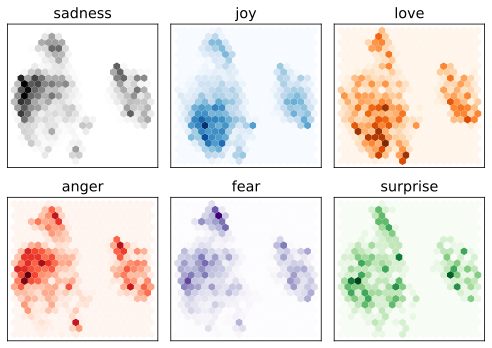

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

##### Training a Simple Classifier

In [60]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [61]:
lr_clf.score(X_valid, y_valid)

0.633

In [62]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

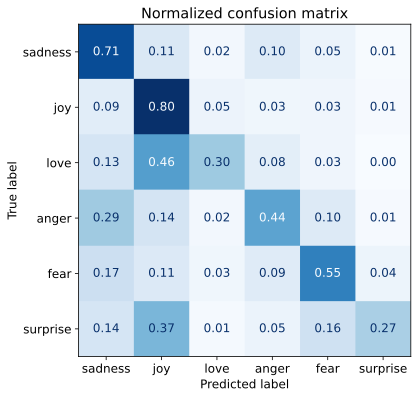

In [63]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

##### Loading a pre-trained model

In [64]:
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

##### Defining the performance metrics

In [65]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

##### Training The Model

In [66]:
from huggingface_hub import notebook_login

notebook_login()

In [67]:
from transformers import pipeline

# Test pipeline to verify installation
classifier = pipeline('sentiment-analysis')
result = classifier("I love using transformers!")
print(result)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9994327425956726}]


In [68]:
import accelerate
print(accelerate.__version__)


0.29.3


In [69]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [70]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.884700,0.341356,0.906500,0.906220
2,0.260300,0.224803,0.923500,0.923400


In [71]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [72]:
preds_output.metrics

{'test_loss': 0.22480346262454987,
 'test_accuracy': 0.9235,
 'test_f1': 0.9233996647482615,
 'test_runtime': 64.2697,
 'test_samples_per_second': 31.119,
 'test_steps_per_second': 0.498}

In [73]:
y_preds = np.argmax(preds_output.predictions, axis=1)

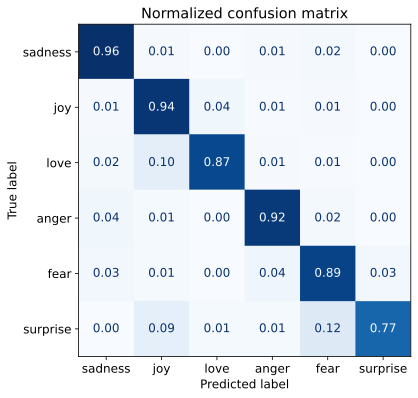

In [74]:
plot_confusion_matrix(y_preds, y_valid, labels)

##### Error analysis

In [75]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [76]:

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [77]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [78]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.301047
1963,i called myself pro life and voted for perry w...,joy,sadness,5.162029
882,i feel badly about reneging on my commitment t...,love,sadness,5.115340
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.023658
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.972242
1111,im lazy my characters fall into categories of ...,joy,fear,4.897297
1801,i feel that he was being overshadowed by the s...,love,sadness,4.625706
1683,i had applied for a job and they had assured m...,anger,joy,4.354327
405,i have been feeling extraordinarily indecisive...,fear,joy,4.327055
1950,i as representative of everything thats wrong ...,surprise,anger,4.160729


In [79]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.018973
189,i leave the meeting feeling more than a little...,sadness,sadness,0.019273
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.019428
954,im feeling disheartened and have not been look...,sadness,sadness,0.019672
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.019676
392,i remember feeling disheartened one day when w...,sadness,sadness,0.019682
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.019717
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.019719
1120,i am feeling a little disheartened,sadness,sadness,0.019721
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.019772


#### Saving & sharing the model

In [80]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")
     

CommitInfo(commit_url='https://huggingface.co/joacorf33/distilbert-base-uncased-finetuned-emotion/commit/78b816f37fc49b248be5c7e368c4bd160a68a1c2', commit_message='Training completed!', commit_description='', oid='78b816f37fc49b248be5c7e368c4bd160a68a1c2', pr_url=None, pr_revision=None, pr_num=None)

In [81]:
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/872 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [82]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
     

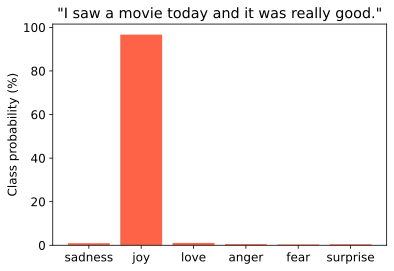

In [84]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='tomato')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()